In [ ]:
!pip install --upgrade evaluate scikit-learn huggingface_hub

In [ ]:
!pip install --upgrade transformers torch accelerate datasets torchvision torchaudio transformers

In [ ]:
from google.colab import files

upload_file = files.upload()
filename = list(upload_file.keys())[0]

Saving final_cleaned.csv to final_cleaned.csv


In [ ]:
import pandas as pd
import io

df_file = pd.read_csv(io.BytesIO(upload_file[filename]))
print(print(df_file.shape))
df_file.info()

(10430, 4)
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     10430 non-null  object
 1   hypothesis  10430 non-null  object
 2   genre       10430 non-null  object
 3   label       10430 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 326.1+ KB


In [ ]:
import unicodedata
# !pip install pyidaungsu
# import pyidaungsu as pds

def clean_burmese(text):
    if not isinstance(text, str):
        return ""
    # text = pds.cvt2uni(text)
    text = text.replace(" ","")
    text = text.replace("။","")
    return unicodedata.normalize('NFC', text)

new_df = pd.DataFrame()
new_df['premise'] = df_file['premise'].apply(clean_burmese)
new_df['hypothesis'] = df_file['hypothesis'].apply(clean_burmese)
new_df['label'] = df_file['label'].astype(int)
#
new_df['label'].value_counts(),new_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     10430 non-null  object
 1   hypothesis  10430 non-null  object
 2   label       10430 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 244.6+ KB


(label
 0    3605
 1    3462
 2    3363
 Name: count, dtype: int64,
 None)

In [ ]:
#START HERE
from sklearn.model_selection import GroupShuffleSplit

import pandas as pd

# new_df

train_splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=127)# 70 - 30
train_idx,split_idx = next(train_splitter.split(new_df,groups = new_df['premise']))
train_df = new_df.iloc[train_idx]
split_df = new_df.iloc[split_idx]

val_test_splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=127)# 100(30) : 15 - 15
val_idx,test_idx = next(val_test_splitter.split(split_df,groups = split_df['premise']))


valid_df = split_df.iloc[val_idx]
test_df = split_df.iloc[test_idx]

train_df.shape,valid_df.shape,test_df.shape


((7302, 3), (1578, 3), (1550, 3))

In [ ]:
from datasets import Dataset, Features, ClassLabel, Value,DatasetDict


features = Features({
    'premise': Value('string'),
    'hypothesis': Value('string'),
    'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'])
})


dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train_df, features=features, preserve_index=False),
    'validation': Dataset.from_pandas(valid_df, features=features, preserve_index=False),
    'test': Dataset.from_pandas(test_df, features=features, preserve_index=False)
})



print(dataset_dict)
print(dataset_dict['train'].features['label'])


print(f"\nTrain size: {len(dataset_dict['train'])}")
print(f"Val size:   {len(dataset_dict['validation'])}")
print(f"Test size:  {len(dataset_dict['test'])}")


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 7302
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1578
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1550
    })
})
ClassLabel(names=['entailment', 'neutral', 'contradiction'])

Train size: 7302
Val size:   1578
Test size:  1550


In [ ]:
from transformers import AutoTokenizer,DataCollatorWithPadding


# mDeBERTa-v3-base-xnli-multilingual-nli-2mil7
# checkpoint = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
checkpoint = "microsoft/mdeberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function_dynamic(examples):
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        max_length=256,
      #  padding="max_length",
    )

tokenized_datasets = dataset_dict.map(tokenize_function_dynamic, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["premise", "hypothesis"])
tokenized_datasets.set_format("torch")


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


print("--- Dynamic Length Check ---")

print(f"Row 0 length: {len(tokenized_datasets['train'][0]['input_ids'])}")
print(f"Row 1 length: {len(tokenized_datasets['train'][1]['input_ids'])}")

Map:   0%|          | 0/7302 [00:00<?, ? examples/s]

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

Map:   0%|          | 0/1550 [00:00<?, ? examples/s]

--- Dynamic Length Check ---
Row 0 length: 50
Row 1 length: 44


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import evaluate
import torch

torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3,
                                                           id2label={0: "entailment", 1: "neutral", 2: "contradiction"},
                                                          label2id={"entailment": 0, "neutral": 1, "contradiction": 2},
                                                           dtype=torch.float32)
model.resize_token_embeddings(len(tokenizer))


accuracy_metric = evaluate.load("accuracy")#for balanced dataset
f1_metric = evaluate.load("f1")#for dataset with one over or under skewed
precision_metric = evaluate.load("precision") # for precise True POsitive where False positive are fatal
recall_metric = evaluate.load("recall")#where False negative are fatal
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]

    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro",
                zero_division=0)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro",
             zero_division=0)["recall"]

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }




Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/mdeberta-v3-base
Key                                        | Status     | 
-------------------------------------------+------------+-
lm_predictions.lm_head.LayerNorm.weight    | UNEXPECTED | 
lm_predictions.lm_head.dense.bias          | UNEXPECTED | 
mask_predictions.LayerNorm.weight          | UNEXPECTED | 
mask_predictions.dense.bias                | UNEXPECTED | 
lm_predictions.lm_head.dense.weight        | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias      | UNEXPECTED | 
lm_predictions.lm_head.bias                | UNEXPECTED | 
deberta.embeddings.word_embeddings._weight | UNEXPECTED | 
mask_predictions.dense.weight              | UNEXPECTED | 
mask_predictions.LayerNorm.bias            | UNEXPECTED | 
mask_predictions.classifier.weight         | UNEXPECTED | 
mask_predictions.classifier.bias           | UNEXPECTED | 
pooler.dense.bias                          | MISSING    | 
classifier.bias                    

In [ ]:
train_model_dir = "./uni_pj_nli_model_train"
metric_choice ="f1"
is_greater_value = True
learn_rate = 1e-5
num_epoch = 15
batch_size = 16
gpu_batch_size = 1

In [ ]:

args = TrainingArguments(
    output_dir=train_model_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learn_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gpu_batch_size,#for gpu space
    fp16=True,
    num_train_epochs=num_epoch,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_choice,
    greater_is_better=is_greater_value,
    save_total_limit=2,
    logging_steps=10,
    warmup_steps=0.2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,

    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


print("Starting training...")
trainer.train()
# trainer.save_model("final_burmese_nli_model")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.064355,1.081379,0.398606,0.333051,0.395993,0.397697
2,0.961047,0.956443,0.486058,0.411695,0.455709,0.490651
3,0.790474,0.845660,0.573511,0.534916,0.575167,0.574994
4,0.720416,0.752132,0.672370,0.669278,0.670009,0.675165
5,0.588779,0.658221,0.716096,0.715020,0.715627,0.717343
6,0.574646,0.613329,0.750317,0.750944,0.753352,0.750661
7,0.593675,0.597813,0.757921,0.757013,0.758142,0.758919
8,0.379312,0.648023,0.768695,0.769114,0.769245,0.769444
9,0.449684,0.660575,0.759823,0.758212,0.766440,0.760062


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.output.LayerNorm.weight', 'deberta.encoder.layer.0.output.LayerNorm.bias', 'deberta.encoder.layer.1.attention.output.LayerNorm.weight', 'deberta.encoder.layer.1.attention.output.LayerNorm.bias', 'deberta.encoder.layer.1.output.LayerNorm.weight', 'deberta.encoder.layer.1.output.LayerNorm.bias', 'deberta.encoder.layer.2.attention.output.LayerNorm.weight', 'deberta.encoder.layer.2.attention.output.LayerNorm.bias', 'deberta.encoder.layer.2.output.LayerNorm.weight', 'deberta.encoder.layer.2.output.LayerNorm.bias', 'deberta.encoder.layer.3.attention.output.LayerNorm.weight', 'deberta.encoder.layer.3.attention.output.LayerNorm.bias', 'deberta.encoder.layer.3.output.LayerNorm.weight', 'deberta.encoder.layer.3.output.Laye

TrainOutput(global_step=4113, training_loss=0.7304373470907399, metrics={'train_runtime': 1553.0438, 'train_samples_per_second': 70.526, 'train_steps_per_second': 4.414, 'total_flos': 2786285393339760.0, 'train_loss': 0.7304373470907399, 'epoch': 9.0})

In [ ]:


model_dir = "./uni_pj_nli_model"
trainer.save_model(model_dir)


print("--- Running Final Test Evaluation ---")
raw_pred_output = trainer.predict(tokenized_datasets["test"])

import json
print(json.dumps(raw_pred_output.metrics, indent=2))

final_preds = np.argmax(raw_pred_output.predictions, axis=-1)
final_labels = raw_pred_output.label_ids

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Final Test Evaluation ---


{
  "test_loss": 0.7139414548873901,
  "test_accuracy": 0.756774193548387,
  "test_f1": 0.7557812004382494,
  "test_precision": 0.7578269693244604,
  "test_recall": 0.7563696801214403,
  "test_runtime": 3.5405,
  "test_samples_per_second": 437.786,
  "test_steps_per_second": 27.397
}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def calculate_basic_metrics(y_true, y_pred):
    accuracy = (y_true == y_pred).mean()
    return {
        "Accuracy": round(accuracy, 4),
        "Error Rate": round(1 - accuracy, 4),
        "Macro F1": round(f1_score(y_true, y_pred, average="macro"), 4),
        "Weighted F1": round(f1_score(y_true, y_pred, average="weighted"), 4)
    }

def create_confusion_matrix_df(y_true, y_pred, class_names):
    labels = [0, 1, 2]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return pd.DataFrame(
        cm,
        index=[f"True {class_names[i]}" for i in labels],
        columns=[f"Pred {class_names[i]}" for i in labels]
    )

def calculate_class_errors(y_true, y_pred, class_names):
    error_bools = pd.Series(y_true != y_pred)
    error_rate = error_bools.groupby(y_true).mean()
    error_rate = error_rate.reindex([0, 1, 2], fill_value=0)

    df_errors = pd.DataFrame({
        "Class": [class_names[i] for i in error_rate.index],
        "Error Rate": error_rate.values,
        "Correct Rate": 1 - error_rate.values
    })
    return df_errors

def plot_class_errors(error_df):
    plt.figure(figsize=(10, 6))
    # Plot the "Correct" part (Blue)
    plt.bar(error_df["Class"], error_df["Correct Rate"], color='skyblue', label='Correct')
    # Plot the "Error" part (Red) on top
    plt.bar(error_df["Class"], error_df["Error Rate"], bottom=error_df["Correct Rate"], color='salmon', label='Error')

    # Add text labels for the error values
    for i, val in enumerate(error_df["Error Rate"]):
        plt.text(i, 1.01, f"{val:.2%}", ha='center', color='red', fontweight='bold')

    plt.title("Class-wise Error Rates (Red = Error, Blue = Correct)", fontsize=14)
    plt.ylabel("Proportion")
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

def plot_overall_performance(metrics_dict):
    plt.figure(figsize=(8, 6))
    keys = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    colors = sns.color_palette("viridis", len(keys))
    bars = plt.bar(keys, values, color=colors)

    plt.title("Overall Model Performance", fontsize=14)
    plt.ylim(0, 1.0)
    plt.ylabel("Score")

    # Add labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, yval, ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_classification_report(report_dict_or_str, class_names):
    # If report is a string, we need it as a dict.
    # Better to call classification_report(..., output_dict=True)
    if isinstance(report_dict_or_str, str):
        print("Tip: Pass output_dict=True to classification_report for better plotting.")
        return

    # Convert dict to DataFrame, excluding 'accuracy' and 'weighted/macro avg'
    df = pd.DataFrame(report_dict_or_str).transpose()
    df = df.loc[list(class_names.values())]

    df[['precision', 'recall', 'f1-score']].plot(kind='barh', figsize=(10, 6), colormap='Set2')
    plt.title("Classification Report Metrics per Class", fontsize=14)
    plt.xlabel("Score")
    plt.xlim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def evaluate_nli_model(df, true_col="label", pred_col="test_label"):
    class_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
    y_true = df[true_col].astype(int).values
    y_pred = df[pred_col].astype(int).values

    # Get report as DICT for plotting and STRING for printing
    report_dict = classification_report(y_true, y_pred, target_names=list(class_map.values()), output_dict=True)
    report_str = classification_report(y_true, y_pred, target_names=list(class_map.values()))

    results = {
        "summary": calculate_basic_metrics(y_true, y_pred),
        "matrix": create_confusion_matrix_df(y_true, y_pred, class_map),
        "class_errors": calculate_class_errors(y_true, y_pred, class_map),
        "report_dict": report_dict,
        "report_str": report_str
    }

    # Run Visualizations
    plot_nli_confusion_matrix(results["matrix"], "NLI Confusion Matrix")
    plot_class_errors(results["class_errors"])
    plot_overall_performance(results["summary"])
    plot_classification_report(results["report_dict"], class_map)

    print("\n--- Full Report ---\n")
    print(results["report_str"])

    return results

import matplotlib.pyplot as plt
import seaborn as sns

def plot_nli_confusion_matrix(cm_df, title):
    """
    Plots a heatmap of the confusion matrix.
    Note: Ensure seaborn and matplotlib are installed.
    """

    sns.set_theme(style="white")


    ax = sns.heatmap(
        cm_df,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar_kws={'label': 'Number of Samples'}
    )


    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)


    plt.xticks(rotation=45)
    plt.yticks(rotation=90)
    plt.tight_layout()


    plt.savefig('nli_confusion_matrix.png')
    print("Visualization saved as 'nli_confusion_matrix.png'")

Visualization saved as 'nli_confusion_matrix.png'


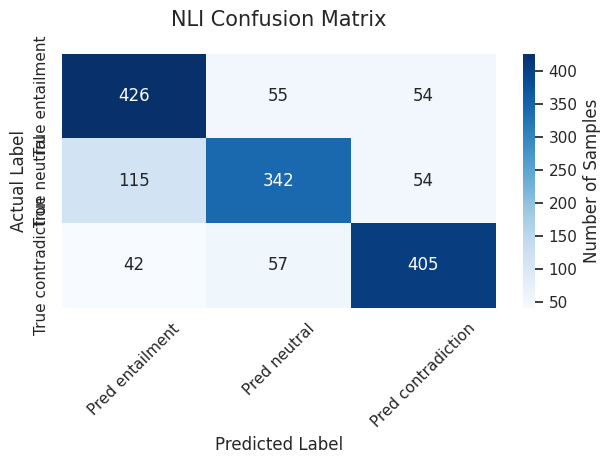

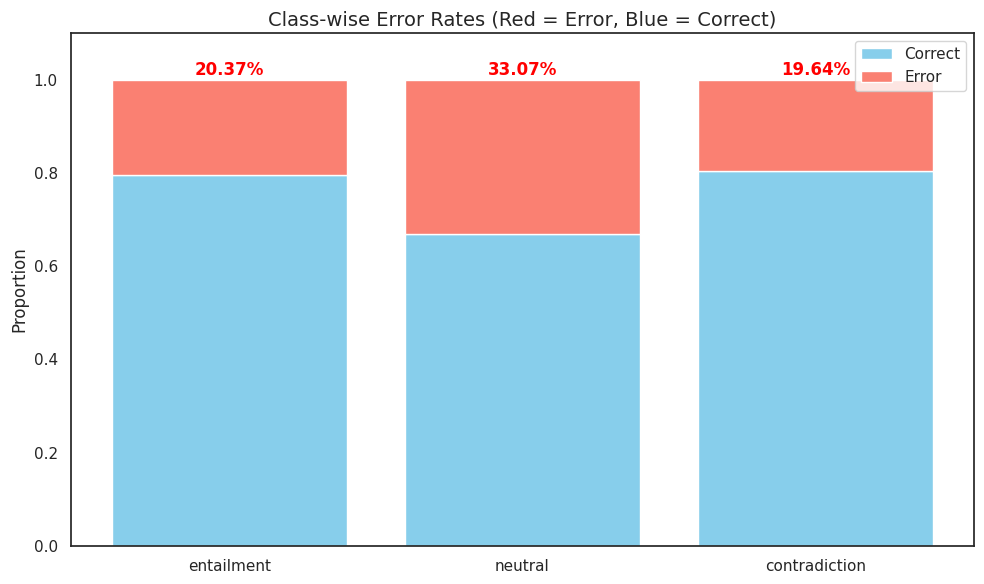

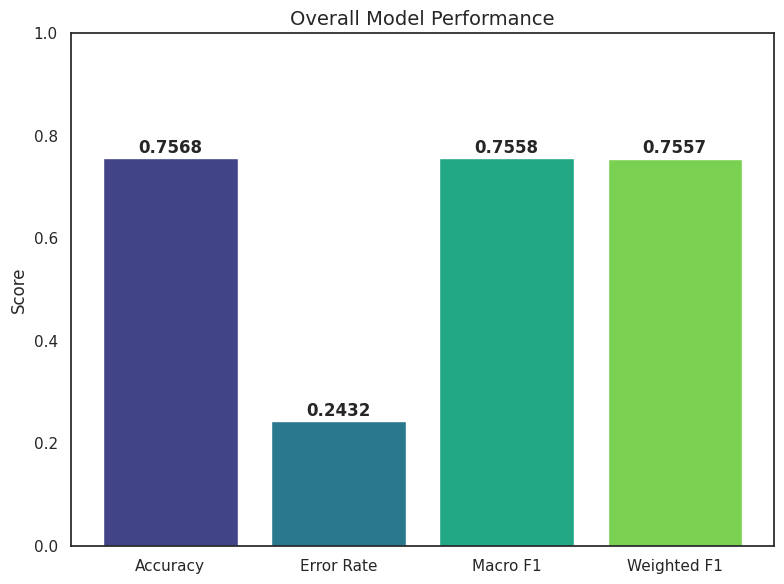

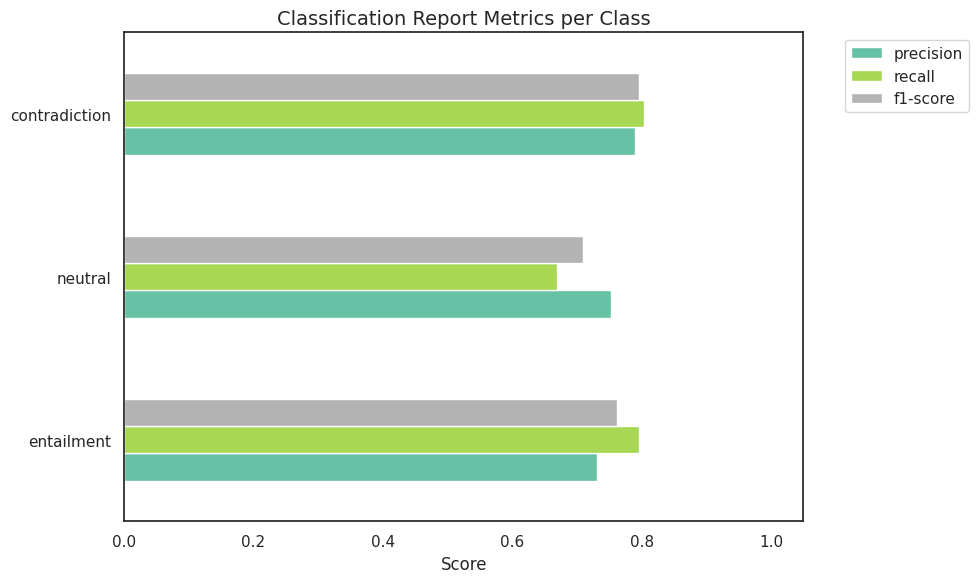


--- Full Report ---

               precision    recall  f1-score   support

   entailment       0.73      0.80      0.76       535
      neutral       0.75      0.67      0.71       511
contradiction       0.79      0.80      0.80       504

     accuracy                           0.76      1550
    macro avg       0.76      0.76      0.76      1550
 weighted avg       0.76      0.76      0.76      1550

--- Basic Metrics ---
{'Accuracy': np.float64(0.7568), 'Error Rate': np.float64(0.2432), 'Macro F1': 0.7558, 'Weighted F1': 0.7557}

--- Class Error Rates (Where is the model failing?) ---
           Class  Error Rate  Correct Rate
0     entailment    0.203738      0.796262
1        neutral    0.330724      0.669276
2  contradiction    0.196429      0.803571


In [ ]:


results_df = pd.DataFrame({
    'label': final_labels,
    'test_label': final_preds
})


eval_results = evaluate_nli_model(results_df, true_col="label", pred_col="test_label")

print("--- Basic Metrics ---")
print(eval_results["summary"])

print("\n--- Class Error Rates (Where is the model failing?) ---")
print(eval_results["class_errors"])

